필요한 라이브러리 및 모듈 임포트

In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random
import plotly.graph_objects as go

학습 설정

In [ ]:
# env 설정
env = nx.DiGraph()
env.add_node('own', proper = 'own', local = ['search'], remote = [], credit = [])

# node의 속성 설정
com = {}
com_node = {}

# local 개수 설정
local_node = set()
for i in range(3):
    local_node.add('Local_c%s' %str(i+1))
    com['Local_c%s' %str(i+1)] = 'local'

com['own'] = 'local'
com_node['local'] = local_node

# remote 개수 설정
remote_node = set()
for i in range(7):
    remote_node.add('R_c%s' %str(i+1))
    com['R_c%s' %str(i+1)] = 'remote'

com['server'] = 'remote'
com_node['remote'] = remote_node

# remote 공격이 가능한 컴퓨터 설정
correct_remote_node = set(['R_c1', 'R_c2', 'R_c3', 'server'])
for crn in correct_remote_node:
    com[crn] = 'correct_remote'

com_node['correct_remote'] = correct_remote_node

connect_node = ['own']
infect_node = []

count = 0

In [ ]:
com

{'Local_c1': 'local',
 'Local_c2': 'local',
 'Local_c3': 'local',
 'own': 'local',
 'R_c1': 'correct_remote',
 'R_c2': 'correct_remote',
 'R_c3': 'correct_remote',
 'R_c4': 'remote',
 'R_c5': 'remote',
 'R_c6': 'remote',
 'R_c7': 'remote',
 'server': 'correct_remote'}

함수

In [ ]:
def attack_check(target, vulnerability):
    '''
    local, remote, credit 이라는 공격이 가능한지에 대해 확인하는 함수
    현재는 target은 remote 권한들만 가지고 있다고 가정한다.
    '''
    local = []
    remote = []
    credit = []

    if com[target] == 'local':
        remote.append('search')
        remote.append('credit')

    elif com[target] == 'remote':
        remote.append('search')
        remote.append('credit')

    elif com[target] == 'corrrect_remote':
        remote.append('search')
        remote.append('credit')

    return local, remote, credit

In [ ]:
def make_edge(node, target, edge_proper):
    '''
    node와 target 사이의 edge를 만드는 함수
    edge가 없으면 만들고, edge는 레벨을 가지므로, 하위 레벨의 경우에만 상위 레벨의 edge를 만드는 것을 허용한다.
    '''
    edge_exists = (node, target) in env.edges()

    if edge_proper == 'remote':
        if not edge_exists or env.edges[node, target]['proper'] != 'lateral':
            env.add_edge(node, target, proper='remote')
        # No action needed if the existing edge is lateral

    elif edge_proper == 'lateral':
        env.add_edge(node, target, proper='lateral')

In [ ]:
def make_knows_edge(node, target, node_proper, vulnerability):
    '''
    1레벨의 edge를 만드는 함수
    '''
    edge_exists = (node, target) in env.edges()

    if not edge_exists:
        env.add_edge(node, target, proper='knows')

    Local, Remote, Credit= attack_check(target, vulnerability)
    env.add_node(target, proper = node_proper, local = Local, remote = Remote, credit = Credit)

In [ ]:
if not set([1]):
    print('check')

In [ ]:
def run_attack(node, vulnerability):
    '''
    local 공격 시도
    '''
    if com[node] != 'local':
        reward = -1
        return reward, False
    if vulnerability == 'search':
        return local_search_vulnerability(node, vulnerability)
    else:
        return -1, False  # Unsupported vulnerability type

In [ ]:
def local_search_vulnerability(node, vulnerability):
    '''
    local 공격의 결과
    '''
    global count

    if node not in connect_node:
        reward  = -1 # Node is not connected
        return reward, False

    if not local_node:
        reward = -1  # Node discovery not possible
        return reward, False

    if count == 0:
        count += 1
        reward = 20  # First local attack discovery
    else:
        reward = 0  # Node discovered

    random_target = random.choice(list(local_node))
    make_knows_edge(node, random_target, 'discovered', vulnerability)
    connect_node.append(random_target)
    local_node.remove(random_target)

    return reward, False

In [ ]:
def run_remote_attack(node, target, vulnerability):
    '''
    원격 공격
    '''
    # Check if target is valid
    if node == target or target not in connect_node:
        return -1, False  # Wrong node selection or invalid target

    # Handle different vulnerability types
    if vulnerability == 'search':
        return remote_search_vulnerability(node, target)
    elif vulnerability == 'credit':
        return remote_credit_vulnerability(target)
    else:
        return -1, False  # Unsupported vulnerability type

In [ ]:
def remote_search_vulnerability(node, target):
    global count

    if not remote_node and not correct_remote_node:
        return -1, False  # Node discovery not possible

    if not com_node[com[target]]:
        return -1, False  # Node discovery not possible

    if count == 1:
        count += 1
        reward = 50  # First remote attack success
    else:
        reward = 0
    if com[target] == 'correct_remote':
        next_node = 'correct_remote'
    else:
        next_node = 'remote'
    random_target = random.choice(list(com_node[next_node]))
    make_edge(node, target, 'remote')
    make_knows_edge(target, random_target, 'discovered', 'search')
    connect_node.append(random_target)
    com_node[next_node].remove(random_target)

    return reward, True

In [ ]:
def remote_credit_vulnerability(target):
    if target in env.nodes() and env.nodes[target].get('credit') != 'acquisition':
        env.nodes[target]['credit'] = 'acquisition'
        return 3, True  # New credit acquired
    else:
        return -3, False  # Credit not acquired or already acquired

In [ ]:
def connect_to_remote_machine(node, target, port, credit):
    '''
    해킹 결과
    '''

    if (node, target) in env.edges() and env.edges[node, target]['proper'] == 'lateral':
        reward = -1 # Repeat
        return reward, False

    if env.nodes[target]['proper'] != 'discovered':
        reward = -1 # Node is not discovered
        return reward, False

    if credit != 'acquisition' or env.nodes[target]['credit'] != 'acquisition':
        reward = -10 # No credit
        return reward, False

    make_edge(node, target, 'lateral')
    env.nodes[target]['proper'] = 'own'
    infect_node.append(target)
    if target == 'server':
        reward = 5000
        return reward, True
    else:
        reward = 7
    return reward, False

In [ ]:
def connect_infect(node, target, port, credit):
    '''
    해킹 공격
    '''
    if target in list(env.nodes()) and env.nodes[target]['proper'] != 'own':
        result = connect_to_remote_machine(node, target, port, credit)
    else:
        reward = -7 # target is not discovered or own
        result = reward, False
    return result

시각화 함수

In [ ]:
co = [[0, 0], [-3, 0], [-1.5, -1.5], [0, -3], [1.5, -1.5], [3, 0], [1.5, 1.5], [0, 3], [-1.5 ,1.5], [5, 5], [-5, -5], [5, -5], [-5, 5]]

In [ ]:
def all_attack():
    attack = list(env.nodes(data=True))
    for i in range(len(env)):
        print(attack[i])

In [ ]:
def coordinate(env):
    pos = {}
    for i in range(len(env)):
        pos[list(env.nodes())[i]] = co[i]
    return pos

In [ ]:
def colormap():
    colormap = []
    for n, d in env.nodes(data=True):
        if d['proper'] == 'own':
            colormap.append('red')
        else:
            colormap.append('lightgreen')
    return colormap

In [ ]:
def edgemap():
    edgemap = []
    for n1, n2, d in env.edges(data=True):
        if d['proper'] == 'remote':
            edgemap.append('orange')
        elif d['proper'] == 'knows':
            edgemap.append('black')
        else:
            edgemap.append('red')
    return edgemap

In [ ]:
def view():
    pos = coordinate(env)
    color_map = colormap()
    edge_map = edgemap()
    proper = nx.get_edge_attributes(env, 'proper')
    nx.draw(env,pos, node_color=color_map, node_size = 1000, with_labels=True,  edge_color=edge_map)

시각화 시작

In [ ]:
env = nx.DiGraph()
env.add_node('own', proper = 'own', local = ['search'], remote = [], credit = [])
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})


('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})


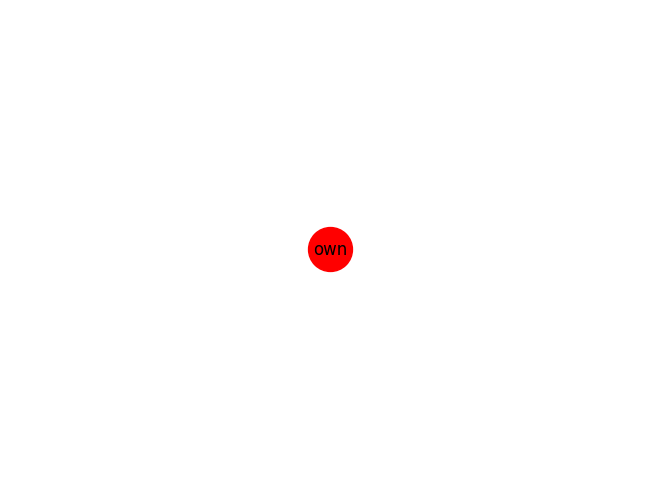

In [ ]:
color_map = []
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})


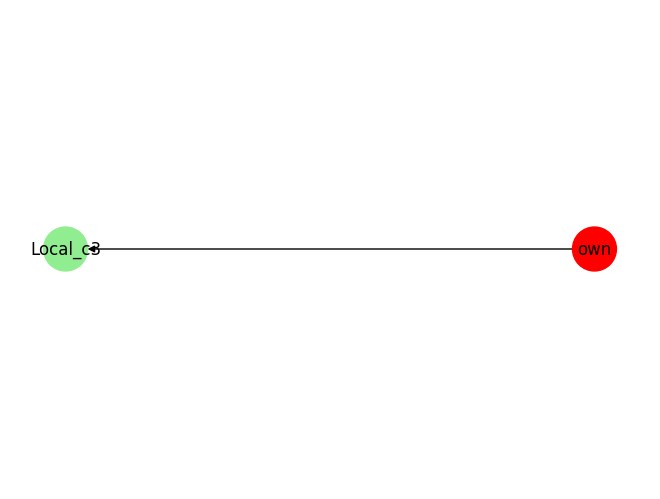

In [ ]:
run_attack('own', 'search')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})


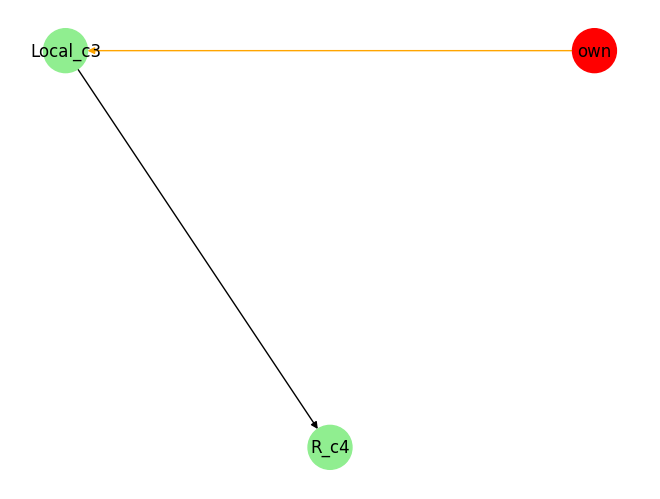

In [ ]:
run_remote_attack('own',connect_node[1],'search')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c3', {'proper': 'discovered', 'local': [], 'remote': [], 'credit': []})


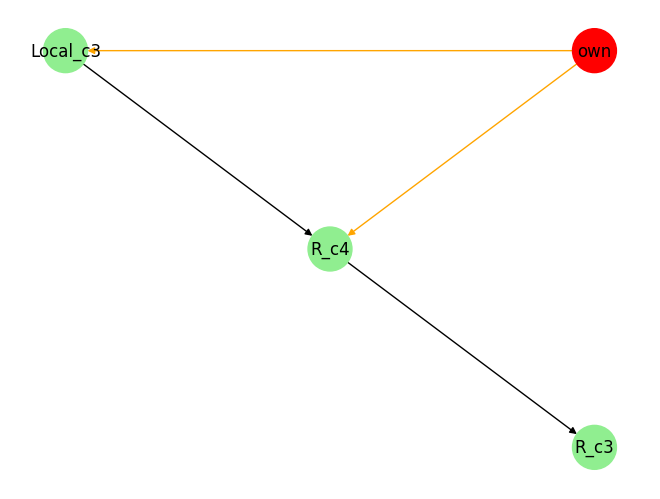

In [ ]:
run_remote_attack('own',connect_node[2],'search')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c3', {'proper': 'discovered', 'local': [], 'remote': [], 'credit': 'acquisition'})


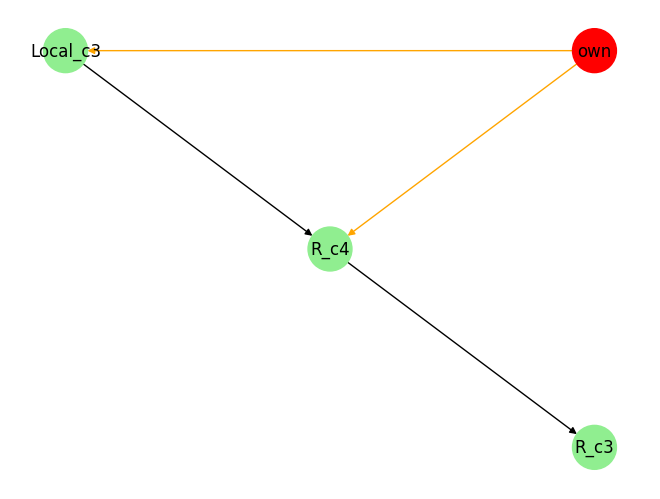

In [ ]:
run_remote_attack('own',connect_node[3],'credit')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c3', {'proper': 'own', 'local': [], 'remote': [], 'credit': 'acquisition'})


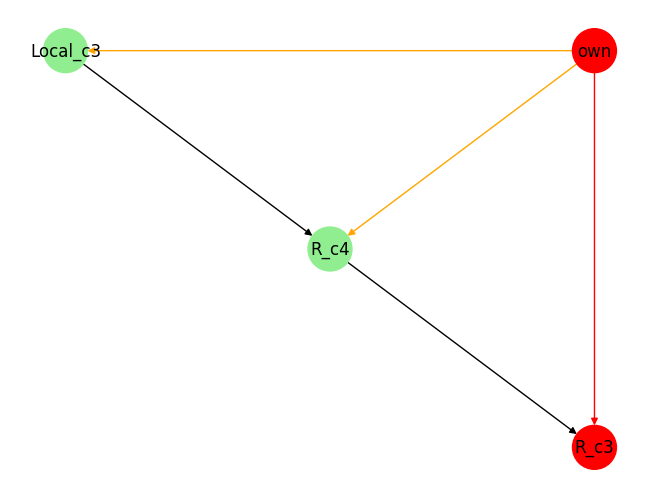

In [ ]:
connect_infect('own', connect_node[3], True, 'acquisition')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c3', {'proper': 'own', 'local': [], 'remote': [], 'credit': 'acquisition'})
('R_c6', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})


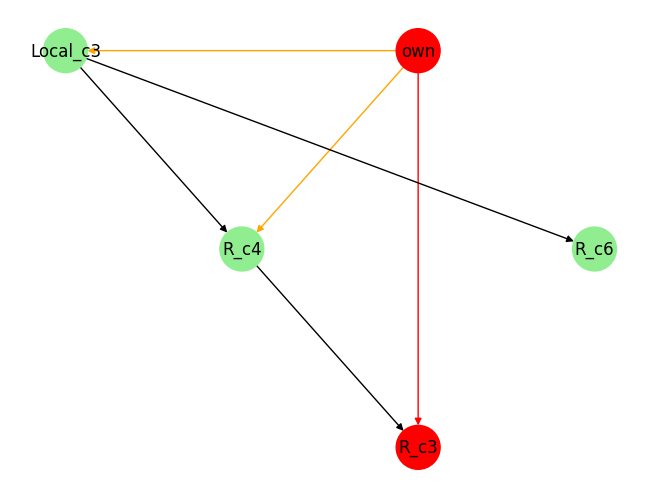

In [ ]:
run_remote_attack('own',connect_node[1],'search')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c3', {'proper': 'own', 'local': [], 'remote': [], 'credit': 'acquisition'})
('R_c6', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c7', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})


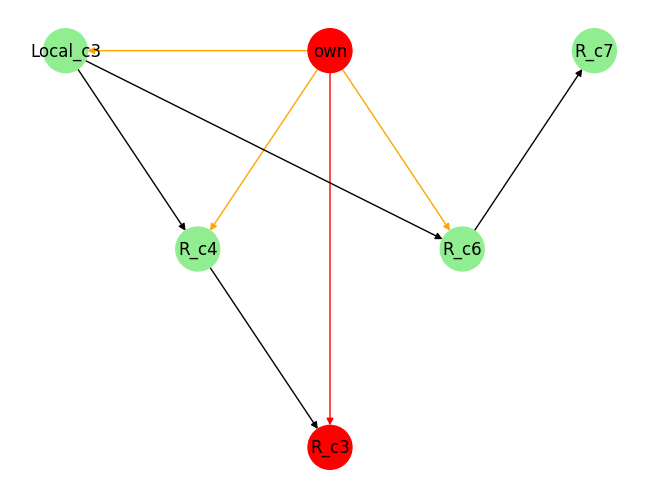

In [ ]:
run_remote_attack('own',connect_node[4],'search')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c3', {'proper': 'own', 'local': [], 'remote': [], 'credit': 'acquisition'})
('R_c6', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c7', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c5', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})


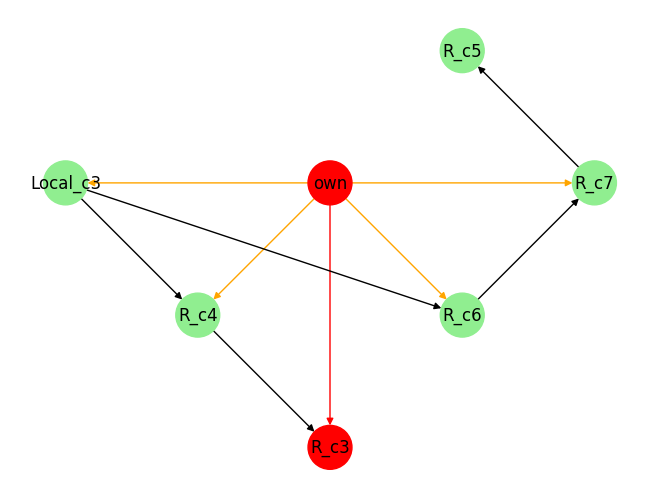

In [ ]:
run_remote_attack('own',connect_node[5],'search')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c3', {'proper': 'own', 'local': [], 'remote': [], 'credit': 'acquisition'})
('R_c6', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c7', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c5', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': 'acquisition'})


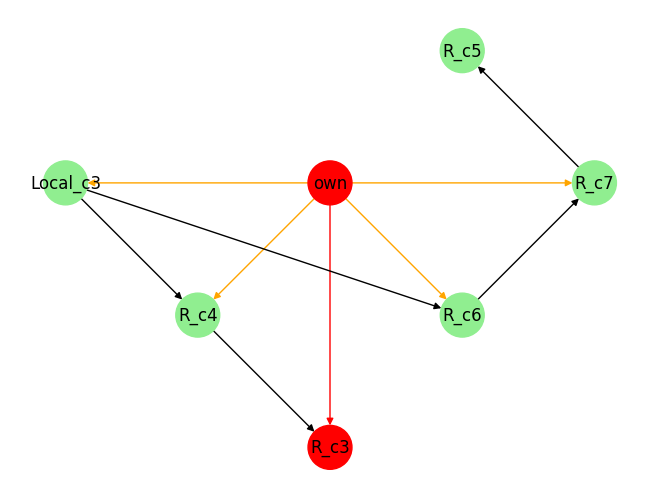

In [ ]:
run_remote_attack('own',connect_node[6],'credit')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c3', {'proper': 'own', 'local': [], 'remote': [], 'credit': 'acquisition'})
('R_c6', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c7', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c5', {'proper': 'own', 'local': [], 'remote': ['search', 'credit'], 'credit': 'acquisition'})


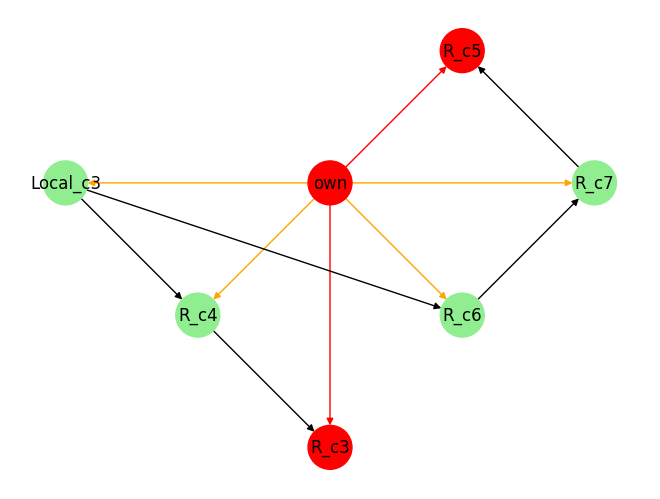

In [ ]:
connect_infect('own', connect_node[6], True, 'acquisition')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c3', {'proper': 'own', 'local': [], 'remote': [], 'credit': 'acquisition'})
('R_c6', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c7', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c5', {'proper': 'own', 'local': [], 'remote': ['search', 'credit'], 'credit': 'acquisition'})
('R_c2', {'proper': 'discovered', 'local': [], 'remote': [], 'credit': []})


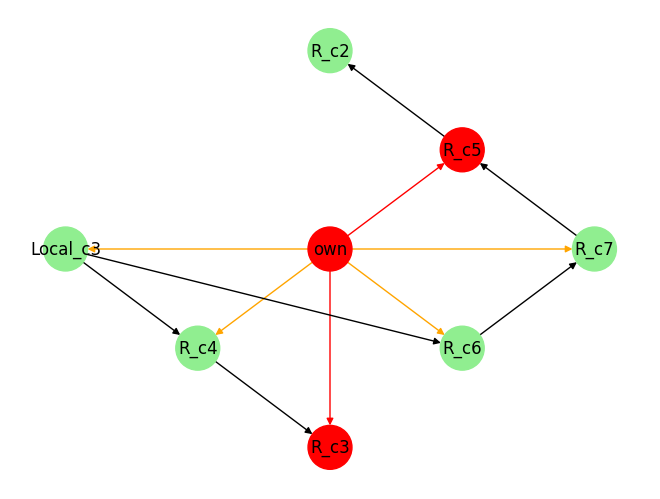

In [ ]:
run_remote_attack('own',connect_node[6],'search')
view()
all_attack()

('own', {'proper': 'own', 'local': ['search'], 'remote': [], 'credit': []})
('Local_c3', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c4', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c3', {'proper': 'own', 'local': [], 'remote': [], 'credit': 'acquisition'})
('R_c6', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c7', {'proper': 'discovered', 'local': [], 'remote': ['search', 'credit'], 'credit': []})
('R_c5', {'proper': 'own', 'local': [], 'remote': ['search', 'credit'], 'credit': 'acquisition'})
('R_c2', {'proper': 'discovered', 'local': [], 'remote': [], 'credit': []})
('R_c1', {'proper': 'discovered', 'local': [], 'remote': [], 'credit': []})


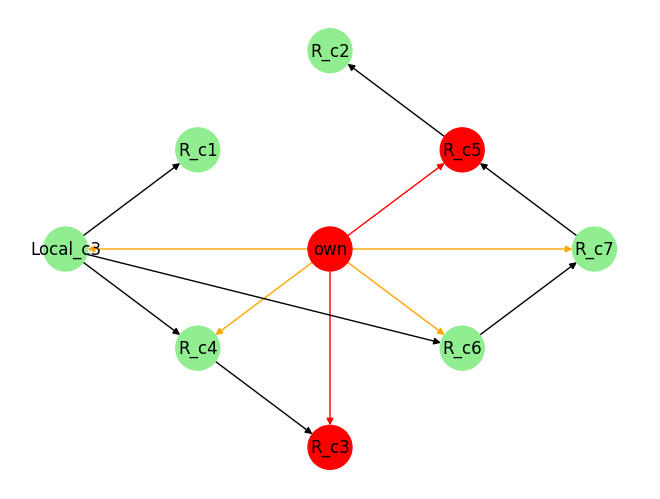

In [ ]:
run_remote_attack('own',connect_node[1],'search')
view()
all_attack()

In [ ]:
connect_infect('own', connect_node[1], True, '획득')

(-10, False)

In [ ]:
run_attack('own', 'search')
run_attack('own', 'search')
run_attack('own', 'search')

(-1, False)

In [ ]:
run_remote_attack('own', connect_node[0], 'search')

(-1, False)

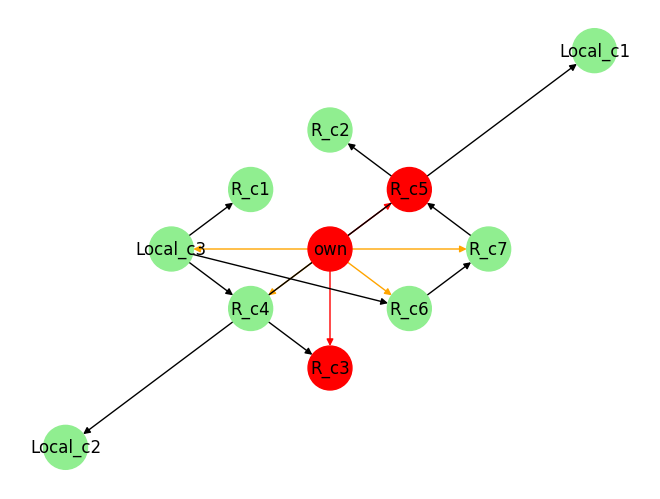

In [ ]:
view()

In [ ]:
len(list(env.nodes(data=True)))

11

In [ ]:
print(run_attack('R_c3', 'search'))

(-1, False)


DQN

In [ ]:
PATH = 'your model path'

In [ ]:
#하이퍼 파라미터
Episodes = 5000
Eps_Start = 0.9 # 무작위 행동 확률 exploration
Eps_End = 0.03

Eps_Decay = 200 # 무작위 행동 감소
Gamma = 0.9 # 현재 reward의 중요도

Lr = 0.001 # learning rate
Batch_size = 64 # 배치 크기

L1 = 48 #발견, 소유, local - remote, credit
L2 = 256
L3 = 128
L4 = 48 #action 12(node 개수) * action(local 1개, remote 2개, infect 1개)

In [ ]:
statelist = ['own', 'L_c1', 'L_c2', 'L_c3', 'R_c1', 'R_c2', 'R_c3', 'R_c4', 'R_c5', 'R_c6', 'R_c7', 'server']

In [ ]:
class DQN:
    def __init__(self):
        self.model = nn.Sequential(
            nn.Linear(L1, 96),
            nn.ReLU(),
            nn.Linear(96, 96),
            nn.ReLU(),
            nn.Linear(96, L4)
        )
        self.optimizer = optim.Adam(self.model.parameters(), Lr)
        self.steps_done = 0 # 학습 반복시 증가
        self.memory = deque(maxlen = 10000)

    def memorize(self, state, action, reward, next_state):
        self.memory.append((state,
                            torch.tensor([[action]]),
                            torch.tensor([reward]),
                            next_state))

    def act(self, state):
        Eps_Threshold = Eps_End + (Eps_Start - Eps_End) * math.exp(-1. * self.steps_done / Eps_Decay)
        self.steps_done += 1

        if random.random() > Eps_Threshold:
            return int(self.model(state).argmax())
        else:
            return random.randint(0, 47)

    def learn(self):
        if len(self.memory) < Batch_size:
            return
        batch = random.sample(self.memory, Batch_size)
        states, actions, rewards, next_states = zip(*batch)
        states = torch.stack(states)
        actions = torch.cat(actions)
        rewards = torch.cat(rewards)
        next_states = torch.stack(next_states)

        current_q = self.model(states).gather(1,actions)

        max_next_q = self.model(next_states).detach().argmax()
        expected_q = rewards + (Gamma * max_next_q)
        loss = F.mse_loss(current_q.squeeze(), expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [ ]:
def make_state(info):
    state = []

    for node in statelist:
        if node in info.nodes():
            state.append(1)
        else:
            state.append(-1)

    for node in statelist:
        if node in info.nodes() and info.nodes[node]['proper'] == 'own':
            state.append(1)
        else:
            state.append(-1)

    for node in statelist:
        if node in info.nodes() and not info.nodes[node]['local']:
            state.append(1)
        else:
            state.append(-1)

    for node in statelist:
        if node in info.nodes() and info.nodes[node]['credit'] == '획득':
            state.append(1)
        else:
            state.append(-1)

    state = torch.FloatTensor(state)
    return state

state 변경시 밑 함수들은 변경해야 합니다.

In [ ]:
def reset(state):
    state = nx.DiGraph()
    state.add_node('own', proper = 'own', local = ['search'], remote = [], credit = [])
    localnode = []
    remotenode = []
    rightremotenode = []
    connectnode = ['own']
    infectnode = []
    for i in range(7):
        remotenode.append('R_c%s' %str(i+1))
        rightremotenode.append('R_c%s' %str(i+1))
    for i in range(3):
        localnode.append('L_c%s' %str(i+1))
    rightremotenode.append('server')
    return state, localnode, remotenode, rightremotenode, connectnode, infectnode

In [ ]:
def action(anum):
    if anum <= 11:
        result = run_attack(statelist[anum], 'search')
    elif anum <= 23:
        result = run_remote_attack('own',statelist[anum-12],'search')
    elif anum <= 35:
        result = run_remote_attack('own',statelist[anum-24],'credit')
    else:
        result = connect_infect('own', statelist[anum-36], True, '획득')
    return result

학습

In [ ]:
agent = DQN()
score_history = []
reward_history = []

In [ ]:
for e in range(1, Episodes+1):

    info, localnode, remotenode, rightremotenode, connectnode, infectnode = reset(info)
    state = make_state(info)
    steps = 0
    REWARD = 0
    count = 0
    while True:
        #view()
        state = state
        Action = agent.act(state)
        Reward, done = action(Action)
        next_state = make_state(info)
        REWARD += Reward
        agent.memorize(state, Action, Reward, next_state)
        agent.learn()

        state = next_state
        steps +=1
        if done:
            model_param = agent.model.state_dict()
            torch.save(model_param, PATH)
            print("episodes: {0} steps: {1} reward: {2}".format(e, steps, REWARD))
            score_history.append(steps)
            reward_history.append(REWARD)
            break

In [ ]:
agent.show()
model_param = agent.model.state_dict()

In [ ]:
plt.plot(score_history)
plt.ylabel('steps')
plt.show()

In [ ]:
plt.plot(reward_history)
plt.ylabel('reward')
plt.show()

model 로드 및 사용

In [ ]:
new_model = DQN()
new_model.model.load_state_dict(torch.load(PATH))
new_model.show()

In [ ]:
info, localnode, remotenode, rightremotenode, connectnode, infectnode = reset(info)
state = make_state(info)
steps = 0
REWARD = 0
view()

반복해서 밑 셀 돌려주시면 됩니다.

In [ ]:
state = state
Action = new_model.act(state)
print(Action)
Reward, done = action(Action)
next_state = make_state(info)
REWARD += Reward
state = next_state
view()